# Machine Learning and Quantum Alchemy: Day 2

## Exercise 01

Implement a Gaussian kernel function: `gaussian_kernel(x1: np.ndarray, x2: np.ndarray) -> float`. Plot the result in one dimension for different values of `x1` and `x2`. The equation is

$$
  k(x_1, x_2) = \exp\left(-\gamma \lVert x_1-x_2\rVert^2\right)
$$

You may assume $\gamma$ is 1.

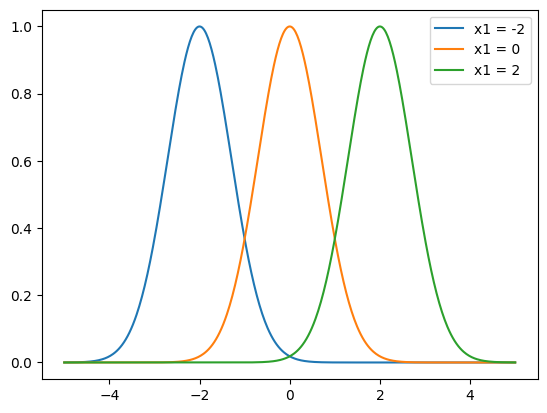

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(x1: np.ndarray, x2: np.ndarray) -> float:
  gamma = 1
  return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

xs = np.linspace(-5, 5, 500)
x1_values = [-2, 0, 2]

for x1 in x1_values:
  ys = [gaussian_kernel(x1, x2) for x2 in xs]
  plt.plot(xs, ys, label = 'x1 = {}'.format(x1))

plt.legend()
plt.show()

## Exercise 02

Using the functions for the Morse potential and the corresponding training data from the previous day, implement Kernel-Ridge-Regression as `fit_krr(training_xs: np.ndarray, training_ys: np.ndarray) -> np.ndarray`:

$$
  \alpha = (\mathbf{K} - \lambda\mathbf{I})^{-1}y
$$

Where $\alpha$ is the model coefficient vector and $\mathbf{K}$ is the Kernel matrix. Each element of that matrix is obtained from applying the kernel function from task 1 to each pair of feature vectors in the training data:

$$
  \mathbf{K}_{ij} = k(x_i, x_j)
$$

Make sure that the function `fit_krr` takes 2D arrays like `scikit-learn` even in the 1D case.

Build a model using your code for some random training data.

In [ ]:
def fit_krr(training_xs: np.ndarray, training_ys: np.ndarray) -> np.ndarray:
  n = len(training_ys)
  K = np.ones((n, n))

  for i in range(n):
    for j in range(i + 1, n):
      K[i, j] = gaussian_kernel(training_xs[i], training_xs[j])
      K[j, i] = K[i, j]

  lval = 1e-10
  alpha = np.linalg.inv(K - lval * np.identity(n)) @ training_ys

  return alpha

## Exercise 03

Implement the predictions in KRR in a function `predict_krr(training_xs: np.ndarray, xprime: np.ndarray, alphas: np.ndarray) -> float`. The prediction equation is

$$
  y'(x') = \sum_i\alpha_i k(x_i, x')
$$

Where the sum runs over all training instances.

In [ ]:
def predict_krr(training_xs: np.ndarray, xprime: np.ndarray, alphas: np.ndarray) -> float:
  yprime = 0

  for i in range(len(alphas)):
    yprime += alphas[i] * gaussian_kernel(training_xs[i], xprime)

  return yprime

## Exercise 04

Let's move on to molecules. Use the following code to obtain the coordinates of naphthalene:



In [ ]:
def get_geometry():
  import requests

  res = requests.get("https://zenodo.org/records/3994178/files/inp.xyz?download=1")
  geos = res.content.decode("utf-8").replace("C", "").replace("H", "")
  geos = geos.split("\n", maxsplit=2)[-1].replace("\n", " ")

  return np.array([float(_) for _ in geos.split()]).reshape(-1, 3)

Write a python function `coulomb_matrix(positions: np.ndarray, nuclear_charges: np.ndarray) -> np.ndarray` to calculate the coulomb matrix representation from the cartesian coordinates and the nuclear charges $Z_i$.

$$
  \begin{split}M_{ij} =\begin{cases}\tfrac{1}{2} Z_{i}^{2.4} & \text{if } i = j \\\frac{Z_{i}Z_{j}}{\| {\bf R}_{i} - {\bf R}_{j}\|}       & \text{if } i \neq j\end{cases}\end{split}
$$

The return value of the function should be a 1D-vector which can be obtained with `.reshape(-1)`.

In [ ]:
def coulomb_matrix(positions: np.ndarray, nuclear_charges: np.ndarray) -> np.ndarray:
  n = len(nuclear_charges)
  M = np.zeros((n, n))

  for i in range(n):
    for j in range(n):
      if i == j:
        M[i, j] = 0.5 * nuclear_charges[i] ** 2.4
      else:
        distance = np.linalg.norm(positions[i] - positions[j])
        M[i, j] = nuclear_charges[i] * nuclear_charges[j] / distance

  return M.reshape(-1)

## Exercise 05

Use `get_data()` in the following code to download a database of about 2286 naphathalene derivatives.

In [ ]:
def get_data():
  import requests

  res = requests.get("https://zenodo.org/records/3994178/files/PBE.txt?download=1")
  charges = []
  energies = []

  for line in res.content.decode("ascii").split("\n")[1:-1]:
    c, e = line.split()
    charges.append([int(_) for _ in c])
    energies.append(float(e))

  charges, energies = np.array(charges, dtype=float), np.array(energies)
  ordering = np.arange(energies.shape[0])
  np.random.shuffle(ordering)

  return charges[ordering, :], energies[ordering]

Use the coulomb matrix representation to build a KRR model of 100 random molecules and predict on the others.

In [ ]:
geo = get_geometry()
charges, energies = get_data()
representations = []

for i in range(100):
  Zs = list(charges[i]) + [1.] * 8
  representations.append(coulomb_matrix(geo, Zs))

alphas = fit_krr(representations, energies[:100])
errors = []

for i in range(len(energies)):
  Zs = list(charges[i]) + [1.] * 8
  rep = coulomb_matrix(geo, Zs)
  errors.append(predict_krr(representations, rep, alphas) - energies[i])